In [2]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-yf_hywwb
  Running command git clone --filter=blob:none -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-yf_hywwb
  Resolved https://github.com/titu1994/tfdiffeq.git to commit ef646f85cbd0821749a03e7ab51e03e16798fab1
  Preparing metadata (setup.py) ... done
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=52343 sha256=f8662e798086d9f06d81d8659a87ba659b722882ff6ccaf00d8ed610ab834980
  Stored in directory: /tmp/pip-ephem-wheel-cache-sexp1p9r/wheels/39/f7/18/5249c8ee2e8306b27455aca27c3b64d272570ddb0323eefc04
Successfully built tfdiffeq


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

In [4]:
data_size = 1000
train_size = 600
batch_time = 200
batch_size = 32
niters = 2000
freq = 100
scaled = True
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

tf.keras.backend.set_floatx('float64')

2022-03-24 11:12:58.916173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 11:12:58.979967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:12:59.095559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:12:59.096912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [5]:
class true_vector_field(tf.keras.Model):
  
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
      
  @tf.function
  def call(self, t, u):
    
    x, y, z = tf.unstack(u[0])
    
    sigma = 14.
    rho = 10.
    beta = 8/3
        
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y-beta*z
    
    return tf.stack([dxdt,dydt,dzdt])

In [6]:
t = tf.linspace(0., 5., num=data_size)
true_u0 = tf.convert_to_tensor([[.5, .5, .5]], dtype=tf.float64)

2022-03-24 11:13:02.010795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:13:02.011645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:13:02.012355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:13:02.013398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:13:02.014103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
with tf.device(device):
    true_u_ = odeint(true_vector_field(), true_u0, t)
    max_ = tf.math.reduce_max(true_u_, axis=None, keepdims=False, name=None)
    true_u = true_u_/max_ if scaled else true_u_
    true_u0 = true_u0/max_ if scaled else true_u0
    true_u_train = true_u[:train_size]
    true_u_test = true_u[train_size:]
    t_train = t[:train_size]

2022-03-24 11:13:02.547796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


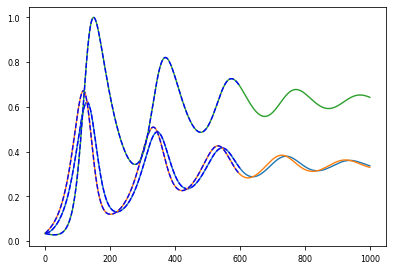

In [8]:
for i in range(3): 
    plt.plot(true_u[:,:,i]) 
    plt.plot(true_u_train[:,:,i],'--b') 

In [9]:
def get_batch():
    s = np.random.choice(np.arange(train_size - batch_time, dtype=np.int64), batch_size, replace=False)
    temp_u = true_u_train.numpy()
    batch_u0 = tf.convert_to_tensor(temp_u[s]) 
    batch_t = t[:batch_time]
    batch_u = tf.stack([temp_u[s + i] for i in range(batch_time)], axis=0) 
    return batch_u0, batch_t, batch_u

In [10]:
class ODEnet(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ODEnet, self).__init__(**kwargs)

        self.dense_1 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1))
        self.dense_2 = tf.keras.layers.Dense(3, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1))

    def call(self, t, u):
        o = self.dense_1(u)
        o = self.dense_2(o)
        return o

In [12]:
with tf.device(device):
    func = ODEnet()

    lr = 1e-3
    optimizer = tf.keras.optimizers.RMSprop(lr)

    for itr in range(1, niters + 1):

        with tf.GradientTape() as tape:
            batch_u0, batch_t, batch_u = get_batch()
            pred_u = odeint(func, batch_u0, batch_t,method='dopri5')
            loss = tf.reduce_mean(tf.abs(pred_u - batch_u))

        grads = tape.gradient(loss, func.variables)
        grad_vars = zip(grads, func.variables)

        optimizer.apply_gradients(grad_vars)

        if itr % freq == 0:
            pred_u = odeint(func, true_u0, t_train)
            tot_loss = tf.reduce_mean(tf.abs(pred_u - true_u_train))
            print('itr: ', itr, '\tloss: ', tot_loss.numpy())


itr:  100 	loss:  0.14252992907727932
itr:  200 	loss:  0.1282505661687243
itr:  300 	loss:  0.12961749230501873
itr:  400 	loss:  0.1301828566039003
itr:  500 	loss:  0.12963951725044331
itr:  600 	loss:  0.13638113876481917
itr:  700 	loss:  0.1403804283815561
itr:  800 	loss:  0.13499818904366886
itr:  900 	loss:  0.1286450969946088
itr:  1000 	loss:  0.12388772244836647
itr:  1100 	loss:  0.12773038947882656
itr:  1200 	loss:  0.12312190154882106
itr:  1300 	loss:  0.12681744250789326
itr:  1400 	loss:  0.12717334412199122
itr:  1500 	loss:  0.12078689581508663
itr:  1600 	loss:  0.12797976666105165
itr:  1700 	loss:  0.12487254123275028
itr:  1800 	loss:  0.1269170676043224
itr:  1900 	loss:  0.13311889159860318
itr:  2000 	loss:  0.11915909561042036


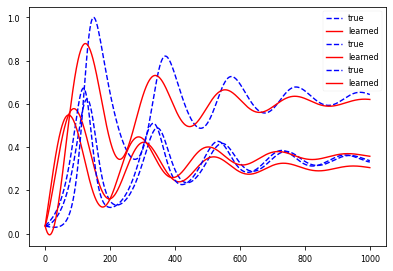

In [14]:
pred_u = odeint(func, true_u0, t)

for i in range(true_u.shape[-1]): 
    plt.plot(true_u[:,:,i],'--b',label='true')
    plt.plot(pred_u[:,:,i],'-r',label='learned')

plt.legend()

# Parametrized version (Dense)

In [15]:
latent_dim = true_u0.shape[-1]
n_params = 3

In [16]:
params_tensor = tf.convert_to_tensor([[14.,10.,8/3]],dtype=tf.float64)
true_u0_param = tf.concat([true_u0,params_tensor],-1)
true_u_param = tf.concat( [true_u,tf.zeros([data_size,1,n_params],dtype=tf.float64)],-1)

In [20]:
def get_batch_param():
    s = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)
    temp_u = true_u.numpy()
    batch_u0 = tf.concat([tf.convert_to_tensor(temp_u[s]),params_tensor*tf.ones([batch_size,1,n_params],dtype=tf.float64)], -1)
    batch_t = t[:batch_time]
    batch_u = tf.concat([tf.stack([temp_u[s + i] for i in range(batch_time)], axis=0), tf.zeros([batch_time,batch_size,1,n_params],dtype=tf.float64)],-1)
    return batch_u0, batch_t, batch_u

In [21]:
class ODEnet_param(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ODEnet_param, self).__init__(**kwargs)

        self.dense_1 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1))
        self.dense_2 = tf.keras.layers.Dense(latent_dim, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1))

    def call(self, t, u):
        o1 = self.dense_1(u)
        o2 = self.dense_2(o1)
        o3 = tf.concat([o2,tf.zeros_like(o2)[:,:,:n_params]],-1) if len(o2.shape)==3 else tf.concat([o2,tf.zeros_like(o2)[:,:n_params]],-1)
        return o3

In [23]:
func = ODEnet_param()
batch_u0, batch_t, batch_u = get_batch_param()
#func.call(0,true_u0_param), func.call(0,batch_u0)

In [29]:
pred_u = odeint(func, batch_u0, batch_t)
#pred_u[-2,:,:,:]

In [31]:
with tf.device(device):
    func = ODEnet_param()

    lr = 1e-3
    optimizer = tf.keras.optimizers.RMSprop(lr)

    for itr in range(1, niters + 1):

        with tf.GradientTape() as tape:
            batch_u0, batch_t, batch_u = get_batch_param()
            pred_u = odeint(func, batch_u0, batch_t)
            loss = tf.reduce_mean(tf.abs(pred_u[:,:,:,:3] - batch_u[:,:,:,:3]))

        grads = tape.gradient(loss, func.variables)
        grad_vars = zip(grads, func.variables)

        optimizer.apply_gradients(grad_vars)

        if itr % freq == 0:
            pred_u = odeint(func, true_u0_param, t)
            tot_loss = tf.reduce_mean(tf.abs(pred_u - true_u_param))
            print('itr: ', itr, '\tloss: ', loss.numpy())


itr:  100 	loss:  0.12355883430038016
itr:  200 	loss:  0.10128072743746744
itr:  300 	loss:  0.11384607660143833
itr:  400 	loss:  0.10343047911135761
itr:  500 	loss:  0.09853721647896267
itr:  600 	loss:  0.0941989981543338
itr:  700 	loss:  0.09719817784756767
itr:  800 	loss:  0.09448769557255318
itr:  900 	loss:  0.07579700216638056
itr:  1000 	loss:  0.06857695422575494
itr:  1100 	loss:  0.07750604190502218
itr:  1200 	loss:  0.0725480305163718
itr:  1300 	loss:  0.08326853873532157
itr:  1400 	loss:  0.06651271141108421
itr:  1500 	loss:  0.06416336610474734
itr:  1600 	loss:  0.05597641140494364
itr:  1700 	loss:  0.056115367634676235
itr:  1800 	loss:  0.05976784593158114
itr:  1900 	loss:  0.04520078330720093
itr:  2000 	loss:  0.047205388490441515


In [35]:
pred_u = odeint(func, true_u0_param, t)

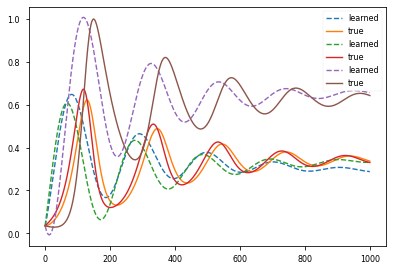

In [36]:
for i in range(3): 
    plt.plot(pred_u[:,:,i],'--',label='learned')
    plt.plot(true_u[:,:,i],label='true')
plt.legend()